Use Data.txt File? (Y/N) :  y



Total 33 Points are Loaded.

Red fitting curve : expfunc = 0.15750703810443786*x^1.1925998383386687, linfunc = 0.4317830010364848*x
Green fitting curve : expfunc = 0.14121546065344273*x^1.1928751338392296, linfunc = 0.387679052843676*x
Blue fitting curve : expfunc = 0.16741105847673354*x^1.189191280928739, linfunc = 0.45080638376540316*x


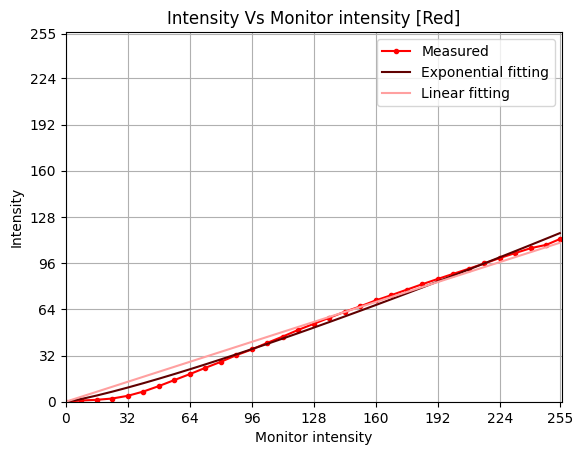

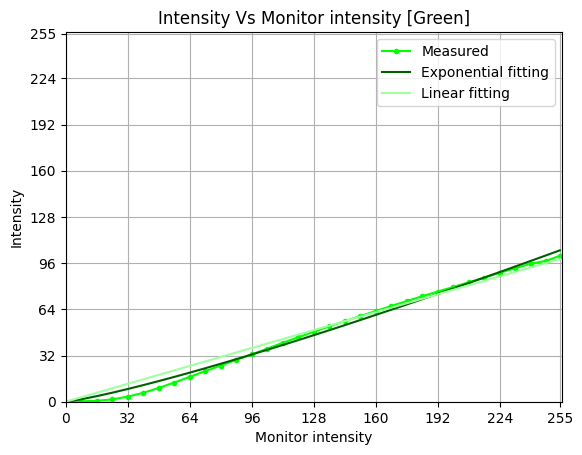

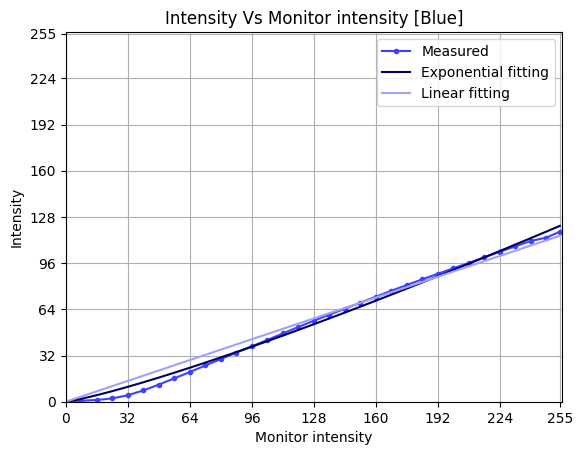

In [6]:
# Radiometric Calibration : Intensity vs Monitor Intensity Graph 얻는 프로그램
import matplotlib as plt
import rawpy
import PIL
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

def getfilelist(fname, level):
    def getkey(str): # yyyymmdd_hhmmss_imagename_#_option.png
        str = str.split('_')
        num = str[4].split('.')
        return (str[0]+str[1]), int(str[3])*(256//level)
    
    path = "./"+fname+"/"
    file_list = os.listdir(path)
    ret = {}
    for i in range(len(file_list)):
        Num = len(file_list[i])
        if Num > 4 and file_list[i][-4:Num] == ".png":
            key, num = getkey(file_list[i])
            if num > 255:
                num = 255
            if ret.get(key,"X") == "X":
                ret[key] = [[],[]]
            ret[key][1].append([path,file_list[i],num])
    return ret

def OpenImage(image):
    img = PIL.Image.open(image[0]+image[1])
    RGB = np.array(img)
    return (img, RGB)

def CloseImage(handle):
    handle[0].close()

def CalcCropAvg(CropRange, Image_handle):
    ImageRGB = Image_handle[1]
    R = CropRange
    Ret = np.mean(ImageRGB[R[1]:R[3]],axis=0)
    Ret = np.mean(Ret[R[0]:R[2]],axis=0)
    return Ret

def GetDataFromPNG(level):
    Input_list = getfilelist("Input",level)
    Cnt = 0
    N = len(Input_list.keys())
    
    for i in range(N):
        name = (list(Input_list.keys()))[i]
        Input_list[name][0] = input("Input Crop Range X1 Y1 X2 Y2 ({}): ".format(name[0:8]+"_"+name[8:])).split(' ')
        #Input_list[name][0] = [800, 2000, 1800, 2800] #for test
        for j in range(len(Input_list[name][0])):
            Input_list[name][0][j] = int(Input_list[name][0][j])
            
    Data = []
    for key, L in Input_list.items():
        Image_list = L[1]
        Num = len(L[1])
        
        Image_handle = []
        for v in Image_list:
            Image_handle.append(OpenImage(v))
            print("{} loaded.".format(v[0]+v[1]))
        print("\nTotal {:d} Images are Loaded.\n".format(Num))
        
        for i in range(Num):
            Data.append([Image_list[i][2],CalcCropAvg(L[0], Image_handle[i])])
            print("{} processed.".format(Image_list[i][1]))
            Cnt += 1
        print("\nTotal {:d} Images are Processed.\n".format(Num))
        
        for v in Image_handle:
            CloseImage(v)

    print(Data)

    Data.sort()
    for v in Data:
        X.append(v[0])
        Y[0].append(v[1][0])
        Y[1].append(v[1][1])
        Y[2].append(v[1][2])
    SaveData(Data) #for test
    return X, Y
        
def SaveData(Data):
    os.makedirs("Output", exist_ok=True)
    file = open("./Output/Data.txt", 'w')
    for i in range(len(Data)):
        v = Data[i]
        file.write("{},{},{},{}\n".format(v[0],v[1][0],v[1][1],v[1][2]))
    file.close()
    
def LoadData(file):
    X = []
    Y = [[],[],[]]
    cnt = 0
    line = file.readline()
    str = line.split(',')
    X.append(float(str[0]))
    Y[0].append(float(str[1]))
    Y[1].append(float(str[2]))
    Y[2].append(float(str[3].replace('\n','')))
    while line:
        cnt+=1
        line = file.readline()
        str = line.split(',')
        if len(str) < 4:
            break
        X.append(float(str[0]))
        Y[0].append(float(str[1]))
        Y[1].append(float(str[2]))
        Y[2].append(float(str[3].replace('\n','')))
    print("\nTotal {:d} Points are Loaded.\n".format(cnt))
    return X, Y
    
X = []
Y = [[],[],[]]
try:
    f = open("./Output/Data.txt", "r")
    if input("Use Data.txt File? (Y/N) : ").lower() == "y":
        X, Y = LoadData(f)
        f.close()
    else:
        level = int(input("Total Whitelevel Number? : "))
        X, Y = GetDataFromPNG(level)
except:
    level = int(input("Total Whitelevel Number? : "))
    X, Y = GetDataFromPNG(level)


gColor = [
    ['#FF0000','#600000','#FFA0A0'],
    ['#00FF00','#006000','#A0FFA0'],
    ['#4040FF','#000060','#A0A0FF']
]
gStr = ["Red","Green","Blue"]
for i in range(3):
    plt.figure()
    if i == 0:
        plt.plot(X, Y[i], '-o', ms=3,color=gColor[i][0])
        plt.title("Intensity Vs Monitor intensity [Red]")
        
    elif i == 1:
        plt.plot(X, Y[i], '-o', ms=3,color=gColor[i][0]) 
        plt.title("Intensity Vs Monitor intensity [Green]")
        
    else:
        plt.plot(X, Y[i], '-o', ms=3,color=gColor[i][0])
        plt.title("Intensity Vs Monitor intensity [Blue]")

    plt.ylabel("Intensity")
    plt.xlabel("Monitor intensity")
    plt.grid(True)
    plt.ylim((0,256))
    plt.xlim((0,256))
    ytick = list(range(0,255,32))
    ytick.append(255)
    plt.yticks(ytick)
    plt.xticks(ytick)
    def expfunc(x, a, b): # fitting model #1 : exponent function
        return a*(x**b)
        
    def linfunc(x, a): # fitting model #2 : linear function
        return a*x
    
    popt, pcov = sci.optimize.curve_fit(expfunc, X, Y[i])
    plt.plot(X, [expfunc(v,*popt) for v in X], '-', ms=3,color=gColor[i][1])
    
    poptl, pcovl = sci.optimize.curve_fit(linfunc, X, Y[i])
    plt.plot(X, [linfunc(v,*poptl) for v in X], '-', ms=3,color=gColor[i][2])
    plt.legend(["Measured","Exponential fitting","Linear fitting"]) 
    
    print(gStr[i]+" fitting curve : expfunc = {}*x^{}, linfunc = {}*x".format(popt[0],popt[1],poptl[0]))